Source code borrowed from :

1. https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
2. https://www.kaggle.com/code/billiemage/object-detection


# Import packages

In [30]:

import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split

import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

from PIL import Image
from pathlib import Path

from engine import train_one_epoch, evaluate
import utils

from IPython.display import Image, display


# Part1: Using available pre-trained models for object detection, conduct inference on a short video (5-10 seconds) of a street scene drawing bounding boxes around detected vehicles.

Step 1. Collect a source video. It may be necessary to divide the video into discrete image frames.

Step 2. Conduct inference on each frame of the video, drawing bounding boxes around detected vehicles.

Step 3. Format the results back into a video.

Use either Pytorch or Tensorflow.

Upload a .zip file containing your .ipynb notebook containing the code utilized and two video files: before inference (without bounding boxes) and after inference (with bounding boxes)

In [9]:
# source_path = './output_frames/'

# IMG_path = Path('./output_frames/images')
# anno_path = Path('./output_frames/annotations')



BASE_PATH = './output_frames/'
XML_PATH = os.path.join(BASE_PATH, "annotations")
IMG_PATH = os.path.join(BASE_PATH, "images/cars")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]

## Visualize samples of training data

In [126]:
from torchvision.datasets import ImageFolder
from torchvision import transforms, models


data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

viz_df = ImageFolder('./output_frames/images/', transform = data_transform)
viz_dataloader = DataLoader(viz_df, batch_size=32)
class_names = viz_df.classes

In [107]:
# Assuming train_dl is your PyTorch DataLoader
data_iter = iter(viz_dataloader)

# Fetch the first batch of data
images, labels = next(data_iter)

len(images),len(labels)

(32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


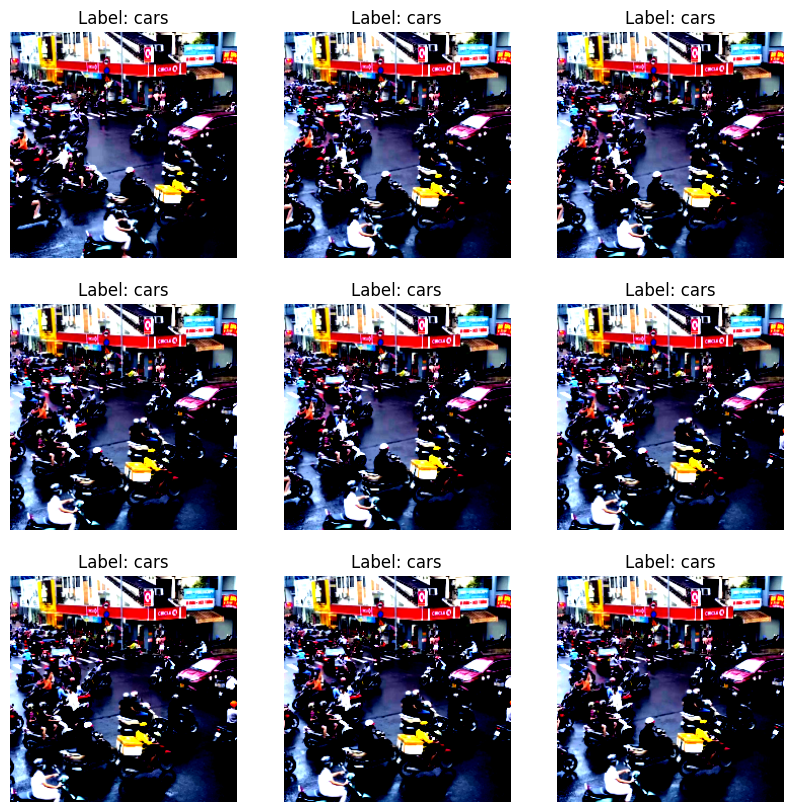

In [108]:
# Plot 9 random images
plt.figure(figsize=(10, 10))
for i in range(9):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    image = images[sample_idx].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()

## Transform annotated XML files to a df

In [127]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id 
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""
    
        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)
    
def xml_files_to_df(xml_files):
    
    """"Return pandas dataframe from list of XML files."""
    
    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}
    
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    
    return df

df = xml_files_to_df(XML_FILES)


# remove .jpg extension from image_id 
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)

df['labels'] = [1 for i in range(len(df))]

# bounding box coordinates point need to be in separate columns

df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack([df['boxes'][i].astype('float') for i in range(len(df['boxes']))])

df.drop(columns=['boxes','names'], inplace=True)

In [128]:
df

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,./output_frames/annotations/frame_0014.xml,./output_frames/images/cars/frame_0014.jpg,frame_0014,1,487.0,542.0,718.0,673.0
1,./output_frames/annotations/frame_0028.xml,./output_frames/images/cars/frame_0028.jpg,frame_0028,1,470.0,543.0,708.0,672.0
2,./output_frames/annotations/frame_0216.xml,./output_frames/images/cars/frame_0216.jpg,frame_0216,1,236.0,663.0,517.0,818.0
3,./output_frames/annotations/frame_0202.xml,./output_frames/images/cars/frame_0202.jpg,frame_0202,1,265.0,651.0,542.0,806.0
4,./output_frames/annotations/frame_0160.xml,./output_frames/images/cars/frame_0160.jpg,frame_0160,1,333.0,611.0,593.0,760.0
...,...,...,...,...,...,...,...,...
348,./output_frames/annotations/frame_0227.xml,./output_frames/images/cars/frame_0227.jpg,frame_0227,1,205.0,671.0,493.0,831.0
349,./output_frames/annotations/frame_0233.xml,./output_frames/images/cars/frame_0233.jpg,frame_0233,1,185.0,675.0,480.0,838.0
350,./output_frames/annotations/frame_0025.xml,./output_frames/images/cars/frame_0025.jpg,frame_0025,1,473.0,542.0,711.0,671.0
351,./output_frames/annotations/frame_0031.xml,./output_frames/images/cars/frame_0031.jpg,frame_0031,1,469.0,546.0,707.0,675.0


In [129]:
# make dictionary for class objects so we can call objects by their keys.
classes= {1:'car'}

## Define and prepare train/val datasets

In [131]:
train_df, val_df = train_test_split(df, test_size=0.2)
train_df.shape,val_df.shape

((282, 8), (71, 8))

In [132]:
train_dataloader = DataLoader(train_df, batch_size=32)
val_dataloader = DataLoader(val_df, batch_size=32)

In [133]:
class VOCDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
       
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
            
            return image, target
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [134]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, IMG_PATH , get_transform_train())
valid_dataset = VOCDataset(val_df, IMG_PATH, get_transform_valid())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

## Load pre-trained model and initialize parameters

In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [136]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [151]:
num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [152]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [176]:
#!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# !git clone https://github.com/pytorch/vision.git
# !cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../


In [173]:
new_loss_function = torch.nn.BCELoss()  # Example: Binary Cross-Entropy Loss

# Replace the existing loss function in the model's configuration
model.roi_heads.box_predictor.cls_loss_func = new_loss_function

## Attempt at fine-tuning pre-trained model

In [174]:
# let's train it for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [ 0/71]  eta: 0:20:40  lr: 0.000076  loss: 1.0749 (1.0749)  loss_classifier: 0.7758 (0.7758)  loss_box_reg: 0.1242 (0.1242)  loss_objectness: 0.1733 (0.1733)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 17.4726  data: 0.0611
Epoch: [0]  [10/71]  eta: 0:18:01  lr: 0.000790  loss: 1.0749 (1.0747)  loss_classifier: 0.7742 (0.7759)  loss_box_reg: 0.1415 (0.1394)  loss_objectness: 0.1519 (0.1580)  loss_rpn_box_reg: 0.0011 (0.0014)  time: 17.7377  data: 0.0603
Epoch: [0]  [20/71]  eta: 0:14:53  lr: 0.001503  loss: 1.0707 (1.0733)  loss_classifier: 0.7777 (0.7771)  loss_box_reg: 0.1415 (0.1399)  loss_objectness: 0.1508 (0.1550)  loss_rpn_box_reg: 0.0011 (0.0012)  time: 17.5248  data: 0.0611
Epoch: [0]  [30/71]  eta: 0:11:43  lr: 0.002217  loss: 1.0611 (1.0691)  loss_classifier: 0.7777 (0.7770)  loss_box_reg: 0.1360 (0.1376)  loss_objectness: 0.1499 (0.1530)  loss_rpn_box_reg: 0.0010 (0.0015)  time: 16.8344  data: 0.0597
Epoch: [0]  [40/71]  eta: 0:08:48  lr: 0.002931  loss: 1.0611 (1

/Users/christopherton/Desktop/SJSU_MSDA/255/DATA255/HW4/engine.py:79: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:228.)
  torch.set_num_threads(1)


creating index...
index created!


AssertionError: Results do not correspond to current coco set

In [160]:
torch.save(model.state_dict(), 'faster_rcnn_state.pth')


## Making inferences

In [166]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=False)

#WEIGHTS_FILE = "./faster_rcnn_state.pth"

num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
# model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/

In [196]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    model.eval()

    detection_threshold = 0.70
    
    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample

In [204]:
pred_path = os.path.join(BASE_PATH, "images_resized")
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

# Define the output video file
output_video = 'predicted_video.mp4'

# Define the video codec and output video dimensions
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # You can also try other codecs like 'XVID', 'MJPG', etc.
video_out = cv2.VideoWriter(output_video, fourcc, 30, (sample.shape[1], sample.shape[0]))


#plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    #if i > 9:break
    #plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  
    
    # samplecopy = np.array(sample, dtype=np.uint16)
    
    # sample_rgb = cv2.cvtColor(samplecopy, cv2.COLOR_BGR2RGB)
    
    video_out.write(np.uint8(sample * 255))

    #plt.axis('off')
    #plt.imshow(sample)
    
# Release the video writer
video_out.release()

print("Video saved successfully!")

Video saved successfully!


# Part 2: Follow the steps in YOLOV8 and attach a screenshot of object detection

Mac: https://pysource.com/2023/03/28/object-detection-with-yolo-v8-on-mac-m1/Links to an external site.

buttery fly dataset: use ~10 images from

https://universe.roboflow.com/yolo-a6y21/squid-bat-butterflyLinks to an external site.

You can also try butterfly video and detect objects. (do not submit it)

In [2]:
import torch
#print(torch.backends.mps.is_available())
from ultralytics import YOLO

In [3]:
# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)


## Test YOLO model on traffic video

In [212]:
results = model(source="vn_traffic.mp4", show=True, conf=0.1, save=True, device='mps')




WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

WARNING ⚠️ NMS time limit 2.050s exceeded
video 1/1 (1/353) /Users/christopherton/Desktop/SJSU_MSDA/255/DATA255/HW4/vn_traffic.mp4: 640x384 21 persons, 2 cars, 25 motorcycles, 266.3ms
video 1/1 (2/353) /Users/christopherton/Desktop/SJSU_MSDA/255/DATA255/HW4/vn_traffic.mp4: 640x384 26 persons, 2 cars, 22 motorcycles, 19.9ms
video 1/1 (3/353) /Users/christopherton/Desktop/SJSU_MSDA/255/DATA255/HW4/vn_traffic.mp4: 640x384 26 persons, 2 cars, 24 motorcycle

: 

## Making inference on butterfly dataset

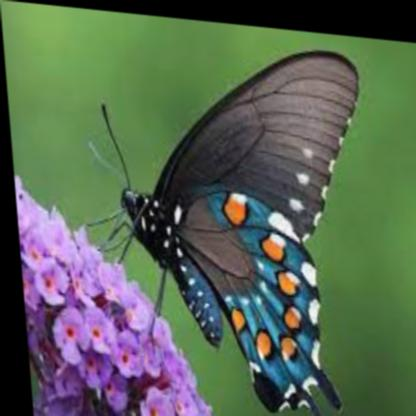

In [15]:
from IPython.display import display, Image
Image(filename='./Squid Bat Butterfly.v2i.yolov8/train/images/01_jpg.rf.28abb439874a51775e1aa43db4868b56.jpg', height=600)

In [22]:
butterfly_path = os.path.join('./Squid Bat Butterfly.v2i.yolov8/', "train")
butterfly_files = [os.path.join(butterfly_path,f) for f in os.listdir(butterfly_path)]
butterfly_files

#os.listdir(butterfly_files[0])

['./Squid Bat Butterfly.v2i.yolov8/train/images',
 './Squid Bat Butterfly.v2i.yolov8/train/labels']

In [ ]:
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='./Squid Bat Butterfly.v2i.yolov8/train/images' save=True

In [34]:
for i, img in enumerate(os.listdir(butterfly_files[0])):
    if i > 9:break
    results = model.predict(source=f'./Squid Bat Butterfly.v2i.yolov8/train/images/{img}', show=True, conf=0.1, save=True, device='mps')


image 1/1 /Users/christopherton/Desktop/SJSU_MSDA/255/DATA255/HW4/Squid Bat Butterfly.v2i.yolov8/train/images/04_jpg.rf.a1a8a6179e89e907886cbe44fd538d35.jpg: 640x640 1 bird, 84.3ms
Speed: 2.5ms preprocess, 84.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /Users/christopherton/Desktop/SJSU_MSDA/255/runs/detect/predict2

image 1/1 /Users/christopherton/Desktop/SJSU_MSDA/255/DATA255/HW4/Squid Bat Butterfly.v2i.yolov8/train/images/53_jpg.rf.b44f33562ad12e6b360039d8af663845.jpg: 640x640 3 birds, 1 clock, 86.4ms
Speed: 2.5ms preprocess, 86.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /Users/christopherton/Desktop/SJSU_MSDA/255/runs/detect/predict2

image 1/1 /Users/christopherton/Desktop/SJSU_MSDA/255/DATA255/HW4/Squid Bat Butterfly.v2i.yolov8/train/images/55_jpg.rf.7205febb32363a2012fea50d1c196281.jpg: 640x640 1 bird, 65.3ms
Speed: 1.7ms preprocess, 65.3ms inference, 0.6ms postprocess per image at shape (1, 3,

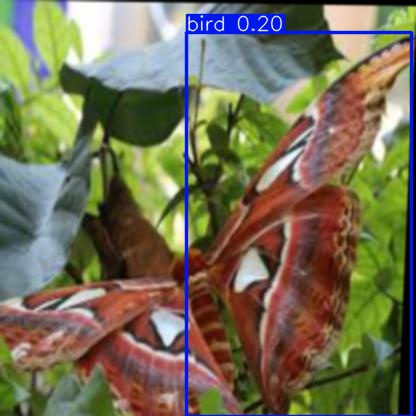

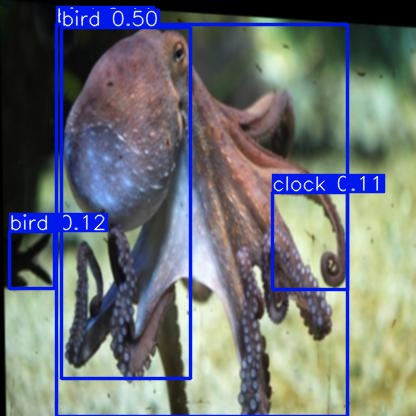

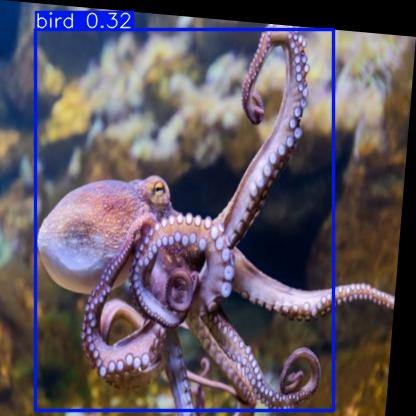

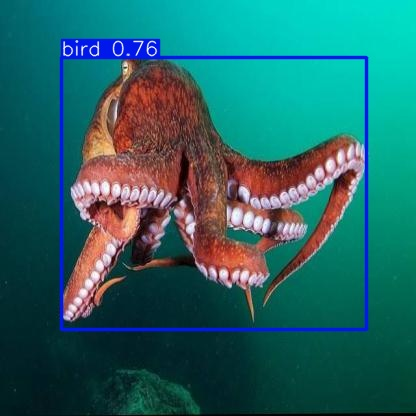

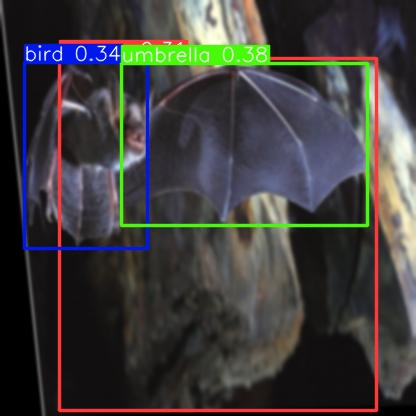

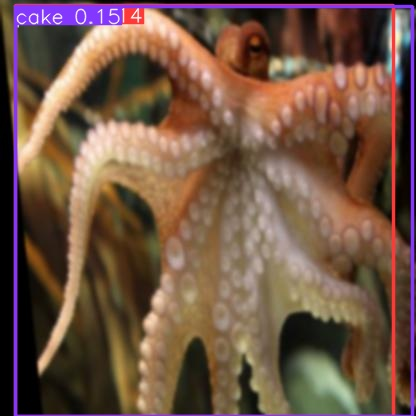

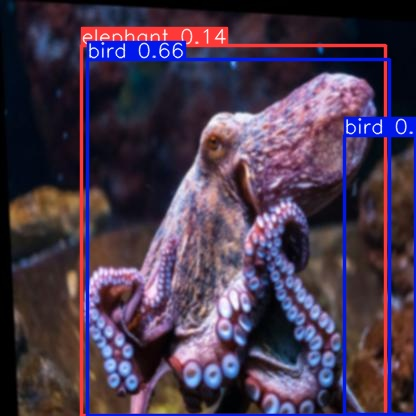

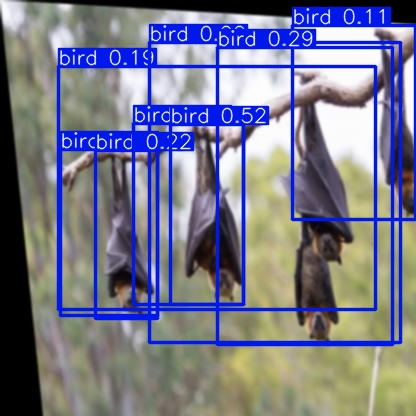

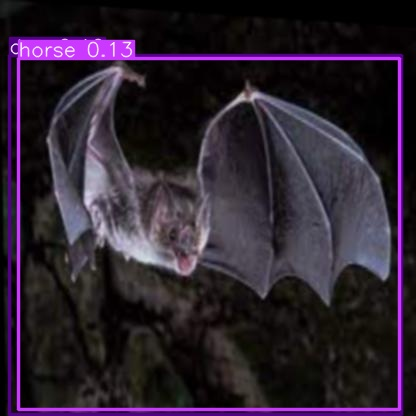

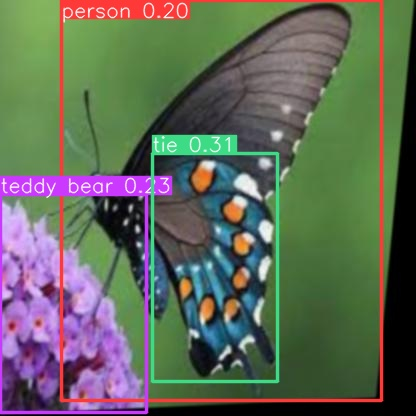

In [39]:
for i in os.listdir('../../runs/detect/predict2/'):
    display(Image(filename=f'../../runs/detect/predict2/{i}', height=600))